In [ ]:
!pip install git+https://github.com/ScaleAGData/scaleag-vito.git@prometheo-integration --quiet

In [ ]:
from pathlib import Path
from scaleagdata_vito.presto.datasets_prometheo import ScaleAgDataset
from scaleagdata_vito.presto.presto_df import load_dataset
from scaleagdata_vito.presto.utils import load_finetuned_model, evaluate_finetuned_model
import pandas as pd

In [ ]:
# Dataset Parameters
start_date="2023-01-01"
end_date="2023-12-31"
composite_window="dekad"
unique_id_column="Field_ID"
output_folder="/home/giorgia/Private/data/geomaize/new_extractions"
models_dir = Path("/home/giorgia/Private/data/geomaize/models/")
experiment_name = "presto-ss-wc-10D-ft-dek-geomaize-lognorm" # "presto-ft-wc-30D-CT-dek-geomaize" #
model_output_dir = models_dir / experiment_name

In [52]:
extractions = load_dataset(
    output_folder,
    composite_window=composite_window,
)
test_ids = pd.read_csv(model_output_dir / "test_sample_ids.csv")
test_df = extractions[extractions['sample_id'].isin(test_ids['sample_id'].to_list())].reset_index(drop=True)

100%|██████████| 3/3 [00:00<00:00, 16.68it/s]


In [ ]:
# visualize distribution to check for outliers to exclude if needed
num_timesteps = extractions.available_timesteps.max()
task_type = "regression"
target_name="Yield kg/H"

We Initialize the training, validation and test datasets objects to be used for training Presto.

In [ ]:
test_ds = ScaleAgDataset(
    dataframe=test_df,
    num_timesteps=num_timesteps,
    task_type=task_type,
    target_name=target_name,
    composite_window=composite_window,
)


2025-08-11 16:21:53.149 | INFO     | scaleagdata_vito.presto.datasets_prometheo:set_num_outputs:145 - Setting number of outputs to 1 for regression task.


2025-08-11 16:22:13.742 | INFO     | scaleagdata_vito.presto.utils:evaluate_finetuned_model:113 - Evaluating the finetuned model on regression task


{'RMSE': 1039.8010627038232, 'MSE': 1081186.25, 'R2_score': -0.2975705862045288, 'MAPE': 0.44492635130882263}


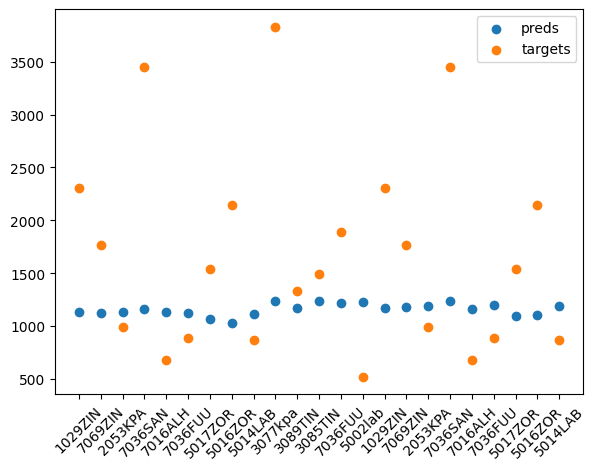

In [55]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

finetuned_model = load_finetuned_model(
    model_path = model_output_dir / experiment_name,
    task_type=task_type,
)

metrics, preds_original_units, targets_original_units = evaluate_finetuned_model(finetuned_model, test_ds, num_workers=0, batch_size=32)
print(metrics)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 2)
plt.scatter(x=np.arange(len(preds_original_units)), y=preds_original_units, label='preds')
plt.scatter(x=np.arange(len(targets_original_units)), y=targets_original_units, label='targets')
plt.xticks(ticks=np.arange(len(test_df)), labels=test_df.sample_id.to_list(), rotation=45)
plt.legend()

2025-08-11 16:22:48.627 | INFO     | scaleagdata_vito.openeo.extraction_utils:load_point_extractions:166 - Found 3 geoparquet files in /home/giorgia/Private/data/geomaize/new_extractions


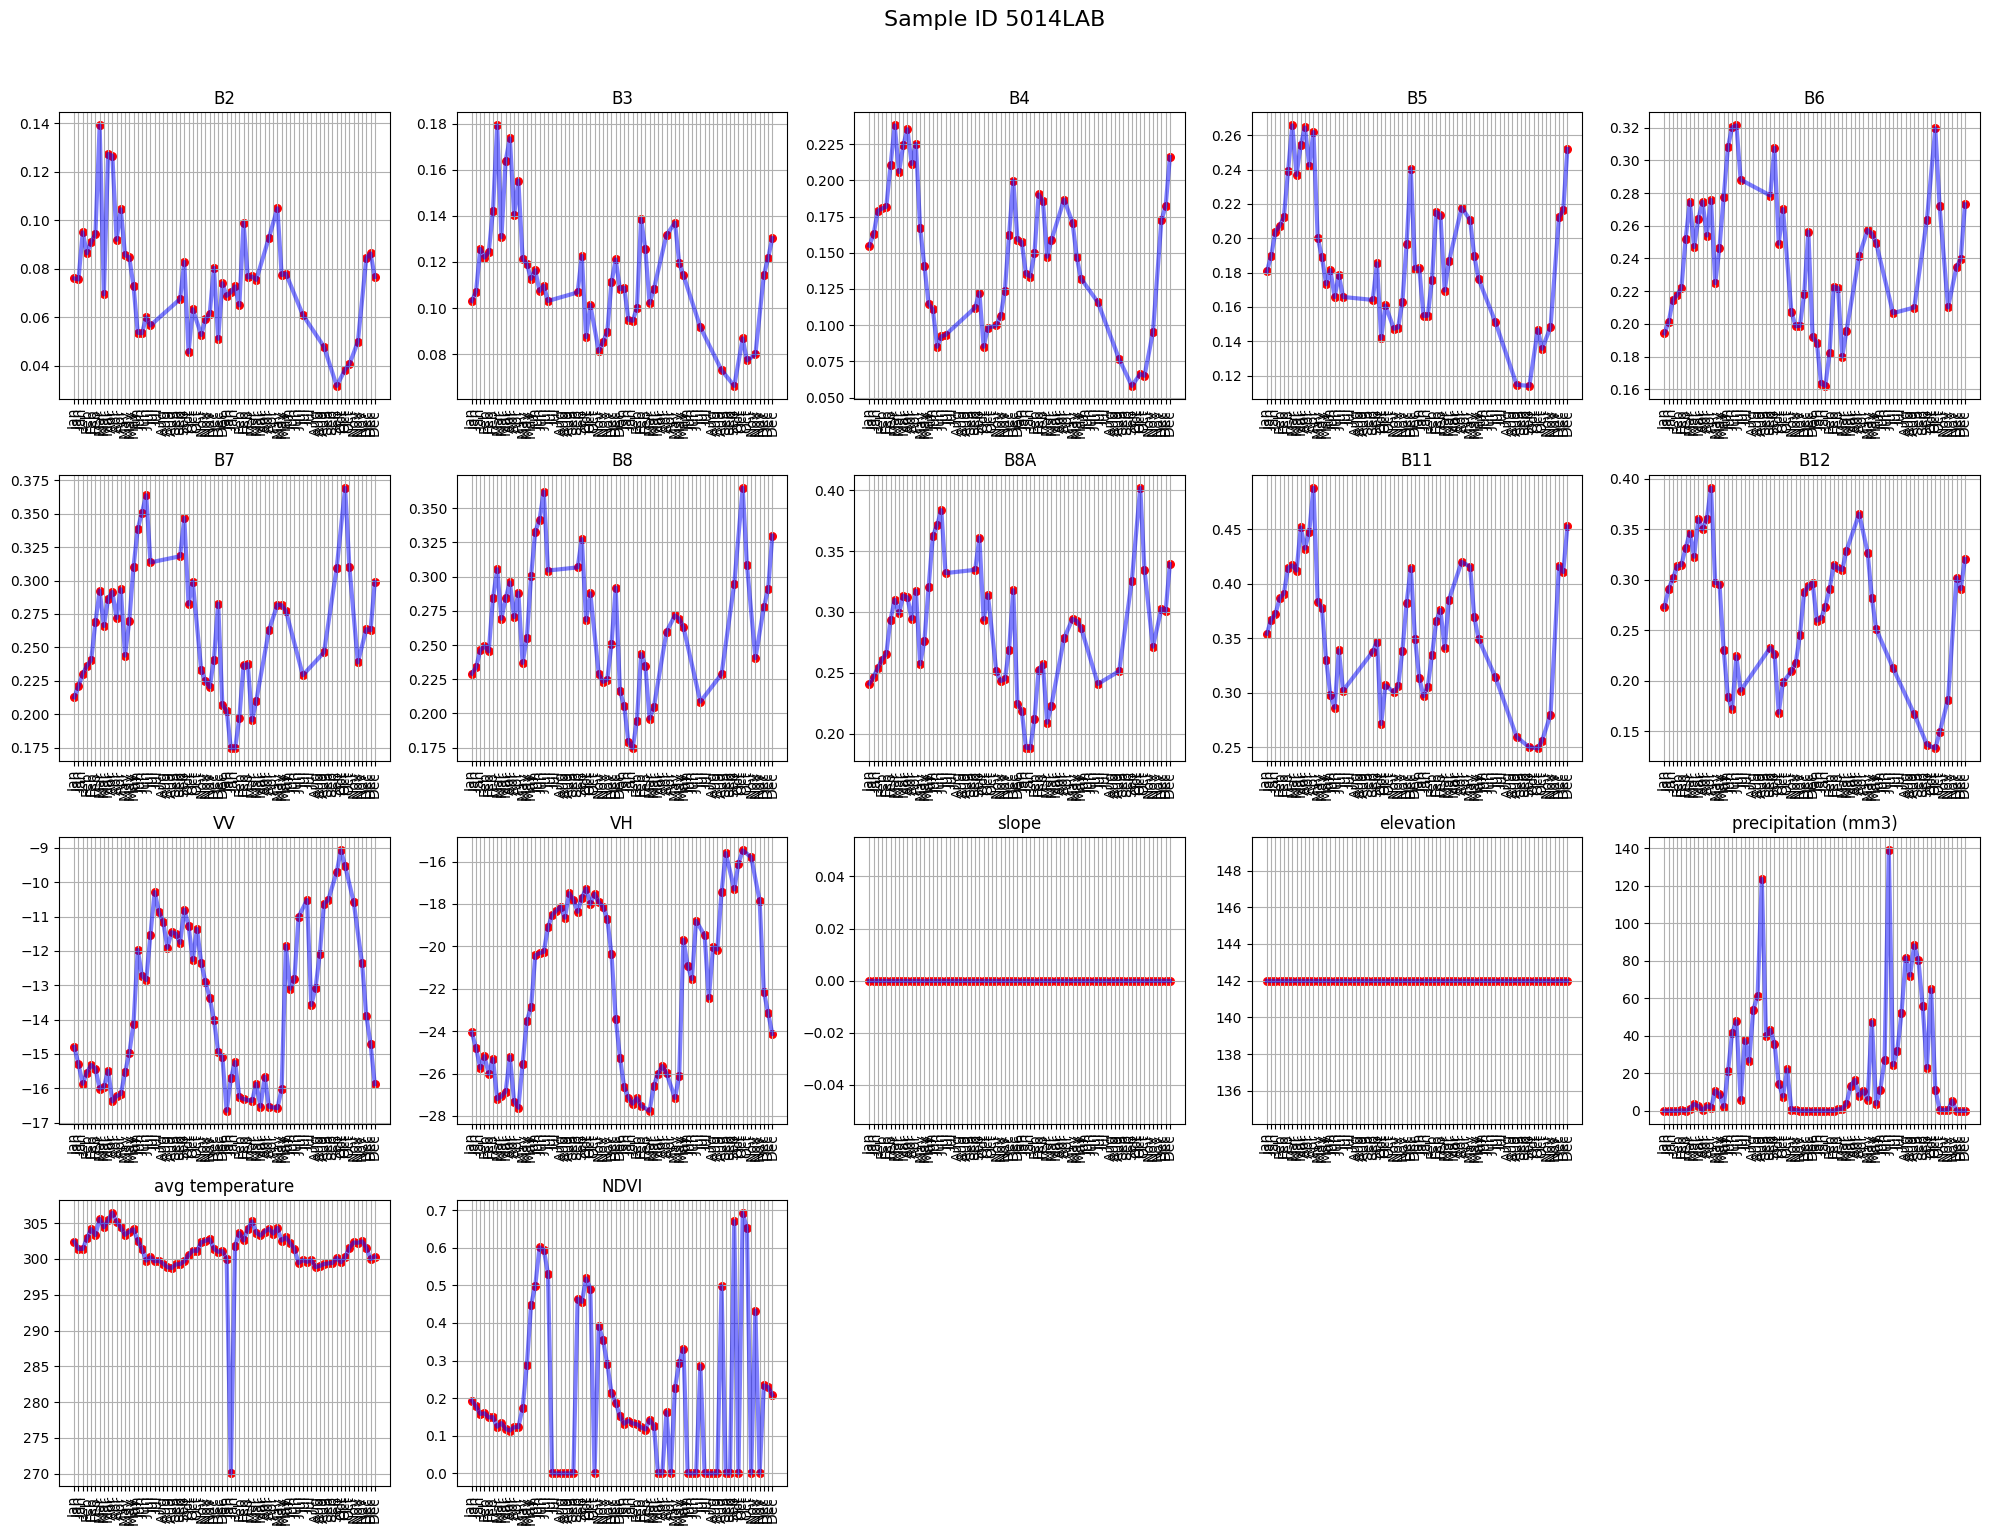

In [57]:
from scaleagdata_vito.openeo.extraction_utils import visualize_timeseries, load_point_extractions

test_gdf = load_point_extractions(
    extractions_dir=Path(output_folder),
    subset=False,
)
test_gdf = test_gdf[test_gdf.sample_id.isin(test_df.sample_id.to_list())]
visualize_timeseries(test_gdf, sample_id='5014LAB')